In [1]:
import torch
import torch_geometric

print(torch.__version__)
print(torch_geometric.__version__)

1.13.1+cu116
2.3.1


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

### 一、GAT的实现

##### 1.继承基类

In [3]:
# GAT层的PyTorch实现

class GATLayer(nn.Module):
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        pass

##### 2.输入线性变换

In [4]:
in_features = 5 # 输入特征维度
out_features = 2 # 输出特征维度

nb_nodes = 3 # 节点数量

In [5]:
W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
nn.init.xavier_uniform_(W.data, gain=1.414) # 使用均匀分布来初始化权重，并根据传入参数来调整分布的标准差
print(W)

input = torch.rand(nb_nodes, in_features) # 元素初始化为在区间[0,1)内的随机数
print(input)

Parameter containing:
tensor([[ 0.7942, -1.0066],
        [ 0.8447,  0.0698],
        [ 0.7497, -1.2069],
        [ 1.1219, -0.4019],
        [ 0.5709, -0.0714]], requires_grad=True)
tensor([[0.2754, 0.3403, 0.8108, 0.1132, 0.9104],
        [0.7436, 0.3395, 0.0074, 0.0418, 0.2936],
        [0.3269, 0.9027, 0.9726, 0.9252, 0.0185]])


In [6]:
h = torch.mm(input, W)
# print(input @ W) "@"实现矩阵乘法
print(h)
print(h.shape)

tensor([[ 1.7608, -1.3426],
        [ 1.0974, -0.7714],
        [ 2.7998, -1.8130]], grad_fn=<MmBackward0>)
torch.Size([3, 2])


In [7]:
N = h.size()[0]
print(N)
# h.size()返回一个torch.Size对象，可以进行进一步操作，如使用索引或切片等
# h.shape()则直接返回一个元组类型

3


###### 3.计算注意力

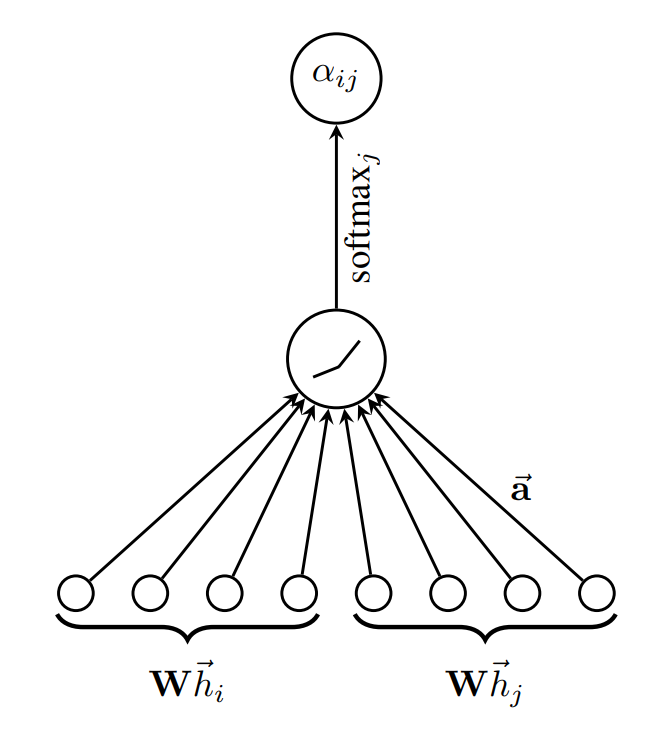

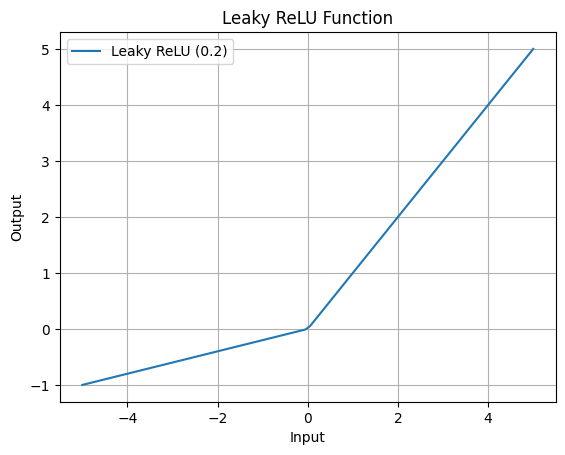

In [8]:
import matplotlib.pyplot as plt

# Leaky ReLU函数
def leaky_relu(x, negative_slope=0.2):
    return np.where(x >= 0, x, negative_slope * x)

# 生成输入数据
x = np.linspace(-5, 5, 100)
# 计算Leaky ReLU输出
y = leaky_relu(x, negative_slope=0.2)
# 绘制图像
plt.plot(x, y, label='Leaky ReLU (0.2)')
plt.title('Leaky ReLU Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU（y<0:y=0.2*x）

torch.Size([4, 1])


In [10]:
print(h.repeat(3, 1)) # h整体作为一个元素，复制成（3,1）这样的张量
print(h.repeat(1, 3))

tensor([[ 1.7608, -1.3426],
        [ 1.0974, -0.7714],
        [ 2.7998, -1.8130],
        [ 1.7608, -1.3426],
        [ 1.0974, -0.7714],
        [ 2.7998, -1.8130],
        [ 1.7608, -1.3426],
        [ 1.0974, -0.7714],
        [ 2.7998, -1.8130]], grad_fn=<RepeatBackward0>)
tensor([[ 1.7608, -1.3426,  1.7608, -1.3426,  1.7608, -1.3426],
        [ 1.0974, -0.7714,  1.0974, -0.7714,  1.0974, -0.7714],
        [ 2.7998, -1.8130,  2.7998, -1.8130,  2.7998, -1.8130]],
       grad_fn=<RepeatBackward0>)


In [11]:
torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1)

tensor([[ 1.7608, -1.3426,  1.7608, -1.3426],
        [ 1.7608, -1.3426,  1.0974, -0.7714],
        [ 1.7608, -1.3426,  2.7998, -1.8130],
        [ 1.0974, -0.7714,  1.7608, -1.3426],
        [ 1.0974, -0.7714,  1.0974, -0.7714],
        [ 1.0974, -0.7714,  2.7998, -1.8130],
        [ 2.7998, -1.8130,  1.7608, -1.3426],
        [ 2.7998, -1.8130,  1.0974, -0.7714],
        [ 2.7998, -1.8130,  2.7998, -1.8130]], grad_fn=<CatBackward0>)

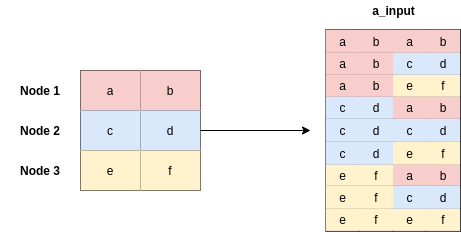

In [12]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)
print(a_input)
print(a_input.shape)

tensor([[[ 1.7608, -1.3426,  1.7608, -1.3426],
         [ 1.7608, -1.3426,  1.0974, -0.7714],
         [ 1.7608, -1.3426,  2.7998, -1.8130]],

        [[ 1.0974, -0.7714,  1.7608, -1.3426],
         [ 1.0974, -0.7714,  1.0974, -0.7714],
         [ 1.0974, -0.7714,  2.7998, -1.8130]],

        [[ 2.7998, -1.8130,  1.7608, -1.3426],
         [ 2.7998, -1.8130,  1.0974, -0.7714],
         [ 2.7998, -1.8130,  2.7998, -1.8130]]], grad_fn=<ViewBackward0>)
torch.Size([3, 3, 4])


In [13]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))
print(e)
print(e.shape)

tensor([[-1.0442, -0.9174, -1.2771],
        [-0.7682, -0.6414, -1.0010],
        [-1.3810, -1.2542, -1.6138]], grad_fn=<LeakyReluBackward0>)
torch.Size([3, 3])


In [14]:
print(torch.matmul(a_input,a))
print(torch.matmul(a_input,a).squeeze(2))

tensor([[[-5.2212],
         [-4.5871],
         [-6.3854]],

        [[-3.8409],
         [-3.2068],
         [-5.0052]],

        [[-6.9050],
         [-6.2709],
         [-8.0692]]], grad_fn=<UnsafeViewBackward0>)
tensor([[-5.2212, -4.5871, -6.3854],
        [-3.8409, -3.2068, -5.0052],
        [-6.9050, -6.2709, -8.0692]], grad_fn=<SqueezeBackward1>)


##### 4.传入图结构（Masked Attention）

In [15]:
# Masked Attention
torch.manual_seed(16)
adj = torch.randint(2, (3, 3)) # 2是生成的随机整数的上限（不包含）

zero_vec  = -9e15*torch.ones_like(e)
print(adj)
print(zero_vec)

tensor([[1, 0, 1],
        [1, 1, 1],
        [0, 1, 1]])
tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


In [16]:
attention = torch.where(adj > 0, e, zero_vec)

print(adj)
print(e)
print(zero_vec)
print(attention)

tensor([[1, 0, 1],
        [1, 1, 1],
        [0, 1, 1]])
tensor([[-1.0442, -0.9174, -1.2771],
        [-0.7682, -0.6414, -1.0010],
        [-1.3810, -1.2542, -1.6138]], grad_fn=<LeakyReluBackward0>)
tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])
tensor([[-1.0442e+00, -9.0000e+15, -1.2771e+00],
        [-7.6819e-01, -6.4136e-01, -1.0010e+00],
        [-9.0000e+15, -1.2542e+00, -1.6138e+00]], grad_fn=<WhereBackward0>)


##### 5.Softmax

In [17]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [18]:
attention

tensor([[0.5579, 0.0000, 0.4421],
        [0.3416, 0.3878, 0.2706],
        [0.0000, 0.5890, 0.4110]], grad_fn=<SoftmaxBackward0>)

In [19]:
h_prime

tensor([[ 2.2201, -1.5505],
        [ 1.7848, -1.2484],
        [ 1.7972, -1.1995]], grad_fn=<MmBackward0>)

In [20]:
print(h_prime, "\n", h) # 根据特征输入MLP之后，根据输出，添加注意力机制（同时考虑之前图的结构信息）

tensor([[ 2.2201, -1.5505],
        [ 1.7848, -1.2484],
        [ 1.7972, -1.1995]], grad_fn=<MmBackward0>) 
 tensor([[ 1.7608, -1.3426],
        [ 1.0974, -0.7714],
        [ 2.7998, -1.8130]], grad_fn=<MmBackward0>)


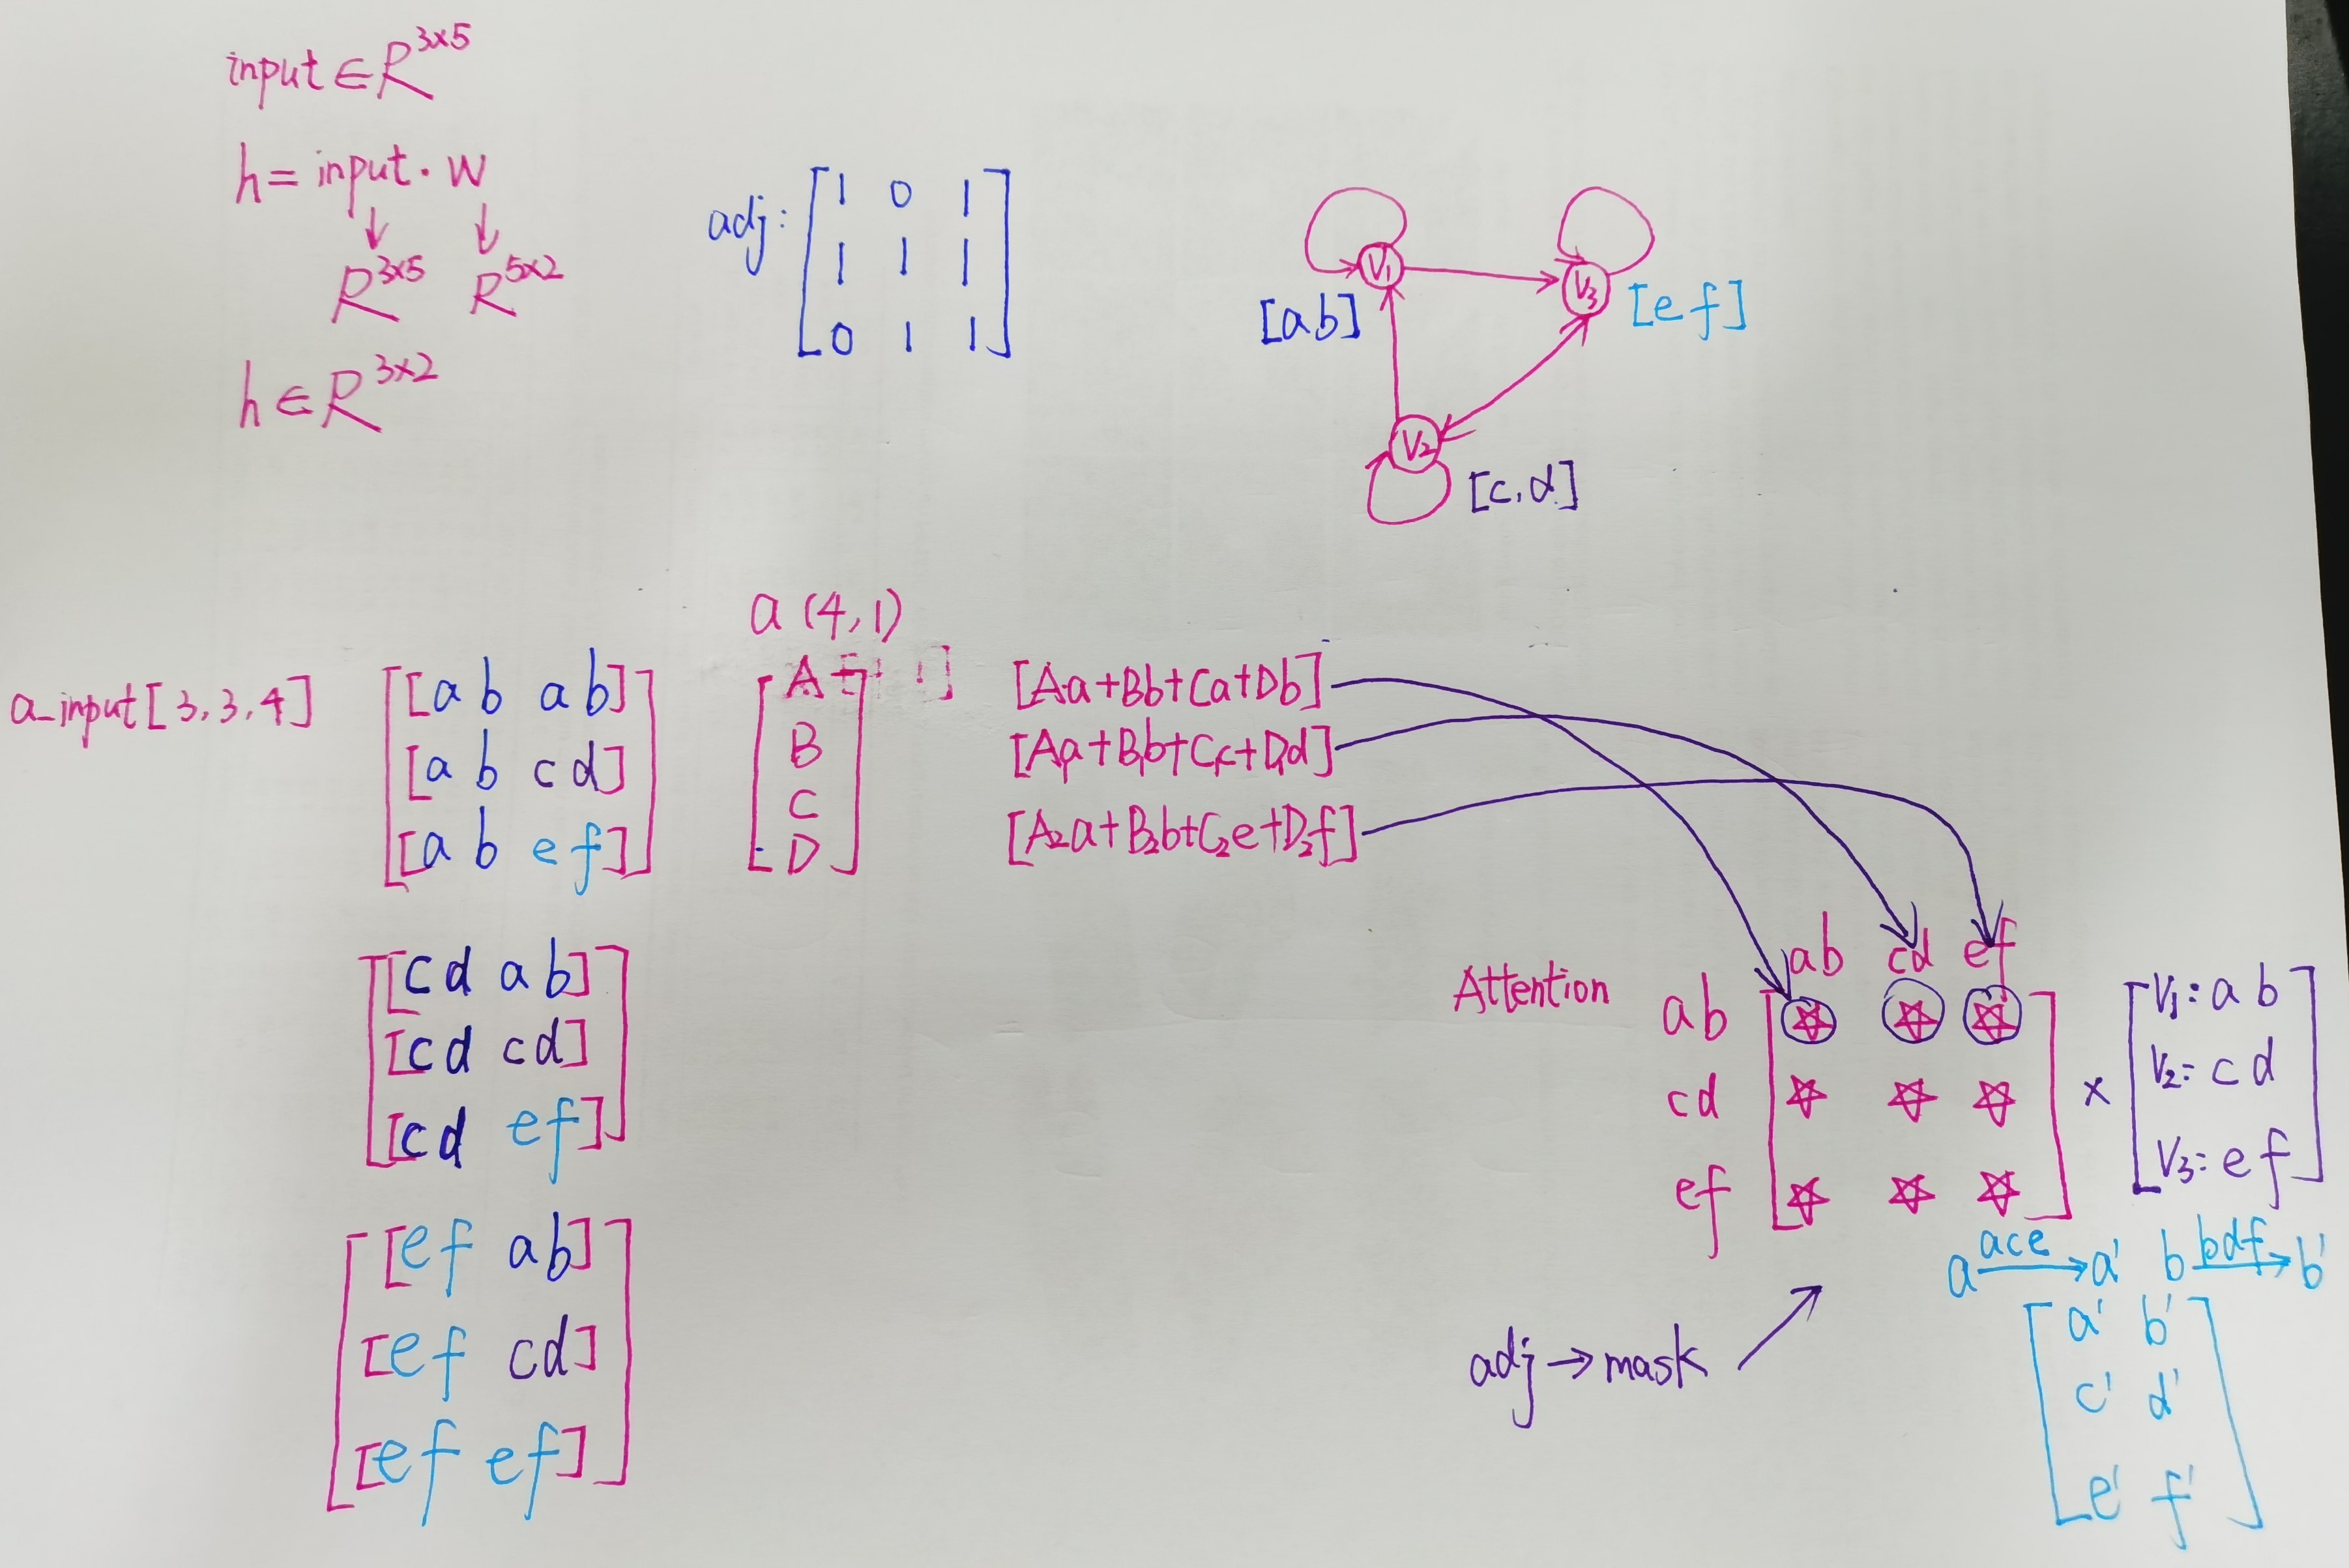

In [21]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2

        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        return h_prime

### 二、GAT的应用

##### 1.数据集

In [22]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]  # 获取第一个图对象

##### 2.GCNConv

In [23]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, output_channels=7):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1433, 64)        
        self.conv2 = GCNConv(64, output_channels)
        
        self.dp = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index) # (num_nodes, num_features=1433) ——> (num_nodes, num_features=64)
        x = F.relu(x)
        
        x = self.dp(x) # Dropout
        x = self.conv2(x, edge_index) # (num_nodes, num_features=64) ——> (num_nodes, dataset.num_classes=7)

        return x

model = GCN()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
  (dp): Dropout(p=0.5, inplace=False)
)
Total parameters: 92231


In [24]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='mean')  # 损失函数

data = data.to(device)

for epoch in range(101):
    #################
    ###   Train   ###
    #################
    model.train() # 训练模式
    optimizer.zero_grad()  # 梯度清0
    train_outputs = model(data.x, data.edge_index)  # 前向传播
    loss = criterion(train_outputs[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 参数更新
    
    train_preds = train_outputs.argmax(dim=1) # 训练预测
    train_correct = train_preds[data.train_mask] == data.y[data.train_mask]  # 训练：预测正确
    train_accuracy = int(train_correct.sum()) / int(data.train_mask.sum())  # 训练节点准确率
    
    ################
    ###   Test   ###
    ################
    model.eval() # 测试模式
    test_outputs = model(data.x, data.edge_index)  # 预测输出
    
    test_preds = test_outputs.argmax(dim=1) # 测试预测
    test_correct = test_preds[data.test_mask] == data.y[data.test_mask]  # 测试：预测正确
    test_accuracy = int(test_correct.sum()) / int(data.test_mask.sum())  # 测试节点准确率

    if epoch % 10 == 0:
        print('Epoch #{:03d}, Loss: {:.4f}, Train_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'.format(epoch, loss, train_accuracy, test_accuracy))

Epoch #000, Loss: 1.9464, Train_Accuracy: 0.1429, Test_Accuracy: 0.3640
Epoch #010, Loss: 1.6868, Train_Accuracy: 0.9286, Test_Accuracy: 0.7020
Epoch #020, Loss: 1.2052, Train_Accuracy: 0.9714, Test_Accuracy: 0.7940
Epoch #030, Loss: 0.6832, Train_Accuracy: 0.9571, Test_Accuracy: 0.8030
Epoch #040, Loss: 0.3399, Train_Accuracy: 0.9786, Test_Accuracy: 0.8110
Epoch #050, Loss: 0.2133, Train_Accuracy: 0.9929, Test_Accuracy: 0.8110
Epoch #060, Loss: 0.1495, Train_Accuracy: 0.9929, Test_Accuracy: 0.8110
Epoch #070, Loss: 0.1351, Train_Accuracy: 0.9929, Test_Accuracy: 0.8170
Epoch #080, Loss: 0.1123, Train_Accuracy: 1.0000, Test_Accuracy: 0.8120
Epoch #090, Loss: 0.1054, Train_Accuracy: 1.0000, Test_Accuracy: 0.8190
Epoch #100, Loss: 0.1057, Train_Accuracy: 1.0000, Test_Accuracy: 0.8180


##### 3.GATConv

In [25]:
import torch.nn as nn
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, output_channels=7):
        super(GAT, self).__init__()

        self.conv1 = GATConv(1433, 64, heads=4, concat=False, negative_slope=0.2, dropout=0.1)        
        self.conv2 = GATConv(64, output_channels, heads=1, concat=False, negative_slope=0.2, dropout=0.1)
        
        self.dp = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index) # (num_nodes, num_features=1433) ——> (num_nodes, num_features=64)
        x = F.relu(x)
        
        x = self.dp(x) # Dropout
        x = self.conv2(x, edge_index) # (num_nodes, num_features=64) ——> (num_nodes, dataset.num_classes=7)

        return x

model = GAT()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

GAT(
  (conv1): GATConv(1433, 64, heads=4)
  (conv2): GATConv(64, 7, heads=1)
  (dp): Dropout(p=0.5, inplace=False)
)
Total parameters: 367893


In [26]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='mean')  # 损失函数

data = data.to(device)

for epoch in range(101):
    #################
    ###   Train   ###
    #################
    model.train() # 训练模式
    optimizer.zero_grad()  # 梯度清0
    train_outputs = model(data.x, data.edge_index)  # 前向传播
    loss = criterion(train_outputs[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 参数更新
    
    train_preds = train_outputs.argmax(dim=1) # 训练预测
    train_correct = train_preds[data.train_mask] == data.y[data.train_mask]  # 训练：预测正确
    train_accuracy = int(train_correct.sum()) / int(data.train_mask.sum())  # 训练节点准确率
    
    ################
    ###   Test   ###
    ################
    model.eval() # 测试模式
    test_outputs = model(data.x, data.edge_index)  # 预测输出
    
    test_preds = test_outputs.argmax(dim=1) # 测试预测
    test_correct = test_preds[data.test_mask] == data.y[data.test_mask]  # 测试：预测正确
    test_accuracy = int(test_correct.sum()) / int(data.test_mask.sum())  # 测试节点准确率

    if epoch % 10 == 0:
        print('Epoch #{:03d}, Loss: {:.4f}, Train_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'.format(epoch, loss, train_accuracy, test_accuracy))

Epoch #000, Loss: 1.9455, Train_Accuracy: 0.1929, Test_Accuracy: 0.4900
Epoch #010, Loss: 1.6769, Train_Accuracy: 0.8929, Test_Accuracy: 0.7630
Epoch #020, Loss: 1.2413, Train_Accuracy: 0.8857, Test_Accuracy: 0.7400
Epoch #030, Loss: 0.8305, Train_Accuracy: 0.8929, Test_Accuracy: 0.7900
Epoch #040, Loss: 0.5352, Train_Accuracy: 0.9571, Test_Accuracy: 0.7890
Epoch #050, Loss: 0.4112, Train_Accuracy: 0.9500, Test_Accuracy: 0.7920
Epoch #060, Loss: 0.3223, Train_Accuracy: 0.9714, Test_Accuracy: 0.8010
Epoch #070, Loss: 0.2389, Train_Accuracy: 0.9786, Test_Accuracy: 0.7910
Epoch #080, Loss: 0.2293, Train_Accuracy: 0.9857, Test_Accuracy: 0.8000
Epoch #090, Loss: 0.1882, Train_Accuracy: 0.9786, Test_Accuracy: 0.7950
Epoch #100, Loss: 0.1711, Train_Accuracy: 0.9929, Test_Accuracy: 0.7890
